# Quickstart: Collisional Ionization Equilibrium

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [2]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"RHS of e- number density equation: {process.network["e-"]}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -1.46719838641439e-26*sqrt(T)/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Heating rate per cm^-3: -1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Rate coefficient: 1.41621465870114e-10/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Recombination rate per cm^-3: 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
RHS of e- number density equation: -1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [3]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)

system.subprocesses

[Collisional Ionization of H,
 Collisional Ionization of He,
 Collisional Ionization of He+,
 Gas-phase recombination of H+,
 Gas-phase recombination of He+,
 Gas-phase recombination of He++]

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

In [4]:
system.heat

-1.55e-26*n_He+*n_e-/T**0.3647 - 1.2746917300104e-21*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252) - 9.37661057635428e-22*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 4.9524176975855e-22*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.86879354565754e-26*sqrt(T)*n_He++*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

In [5]:
system.print_network_equations()

dn_He/dt = -2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108))
dn_He+/dt = 2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108)) + 5.66485863480458e-10*n_He++*n_e-/(sqrt(T)*(0.00059608348423851*sqrt(T) + 1.0)**1.748*(0.281807561832489*sqrt(T) + 1.0)**0.252)
dn_He++/dt = 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.66485863480458e-10*n_He++*n_e-/(sqrt(T)*(0.00059608348423851*sqrt(T) + 1.0)**1.748*(0.281807561832489*sqrt(T) + 1.0)**0.252)
dn_e-/dt = 5.85e-11*sqrt(T)*n_H*n_e

## Solving ionization equilibrium

We would like to solve for ionization equilibrium given a temperature $T$, overall H number density $n_{\rm H,tot}$, and helium mass fraction $Y$.  We define a dictionary of those input quantities and also one for the initial guesses of the number densities of the species in the reduced network.

In [6]:
Tgrid = np.logspace(3,6,10**6)
ngrid = np.ones_like(Tgrid) * 100
Ygrid = 0.24*np.ones_like(Tgrid)

knowns = {"T": Tgrid, "n_Htot": ngrid, "Y": Ygrid}


Note that by default, the solver only directly solves for $n_{\rm H}$, $n_{\rm He}$ and $n_{\rm He+}$ because $n_{\rm H+}$, $n_{\rm He++}$, and $n_{\rm e-}$ are eliminated by conservation equations. So we only need initial guesses for those 3 quantities. By default the solver takes abundances $x_i = n_i / n_{\rm H,tot}$ as inputs and outputs.

# Solving thermochemical equilibrum

In [7]:
from pism.processes import FreeFreeEmission, LineCoolingSimple
system +=  sum([FreeFreeEmission(i) for i in ("H+", "He+", "He++")]) + sum([LineCoolingSimple(i) for i in ("H", "He+",)])
system.heat += 1e-27 * sp.Symbol("n_Htot")
system.network["e-"] += 1e-16 * sp.Symbol("n_Htot")
system.network["H+"] += 1e-16 * sp.Symbol("n_Htot")
system.network["H"] -= 1e-16 * sp.Symbol("n_Htot")
T = sp.Symbol("T")

# C+ cooling - assumes 
system.heat -= 1e-27 * sp.Symbol("n_Htot") * sp.exp(-91.211 / T) * (4890 / sp.sqrt(T) *  (1e-4 * sp.Symbol("n_H")) + 0.47 * T**0.15 * sp.Symbol("n_Htot"))
ngrid = np.logspace(-3,3,1000)
Ygrid = 0.24*np.ones_like(ngrid)

knowns = {"n_Htot": ngrid, "Y": Ygrid} #, "n_He": 0.24/(4-4*0.24)*ngrid, "n_He+": np.zeros_like(ngrid)} #, "Z_C": np.ones_like(ngrid), "n_C+": ngrid * 1e-4}


guesses = {
    "T": 1e3 * np.ones_like(ngrid),
    "H": ngrid*0.99,
    "He": 0.24/(4-4*0.24)*ngrid*0.99,
    "He+": 0.24/(4-4*0.24)*ngrid*0.01
}

sol = system.steadystate(knowns, guesses,tol=1e-3,input_abundances=False, output_abundances=False,careful_steps=20)#,logify=True)
print(sol)

{'He': Array([9.99999991e-38, 7.72398465e-12, 4.22385564e-12, 4.92023262e-12,
       9.46949631e-14, 2.69786775e-12, 4.11435724e-13, 1.21101844e-11,
       1.03873019e-12, 5.30214891e-12, 2.67405390e-12, 5.65719414e-14,
       1.43457717e-12, 9.90081159e-14, 4.64653836e-11, 1.01795152e-11,
       4.28139501e-05, 1.23599486e-03, 4.28796950e-04, 8.00982161e-05,
       1.00763293e-03, 9.99999991e-38, 1.52000284e-04, 2.07457342e-04,
       1.89650594e-03, 9.99999991e-38, 3.92317626e-04, 9.99999991e-38,
       9.99999991e-38, 8.81498330e-04, 1.51897734e-03, 1.49136549e-03,
       1.02271453e-01, 9.99999991e-38, 5.56402467e-03, 3.60029563e-02,
       2.19217222e-09, 2.14100839e-03, 9.99999991e-38, 4.05662286e-05,
       9.99999991e-38, 2.84063659e-04, 9.99999991e-38, 2.83303508e-03,
       9.99999991e-38, 9.99999991e-38, 7.59126380e-08, 5.14730951e-03,
       1.35216734e-03, 2.27713352e-11, 4.53512417e-03, 2.71226250e-04,
       6.39997015e-04, 3.40411199e-10, 9.99999991e-38, 1.51865609e-09,

(1, 100000.0)

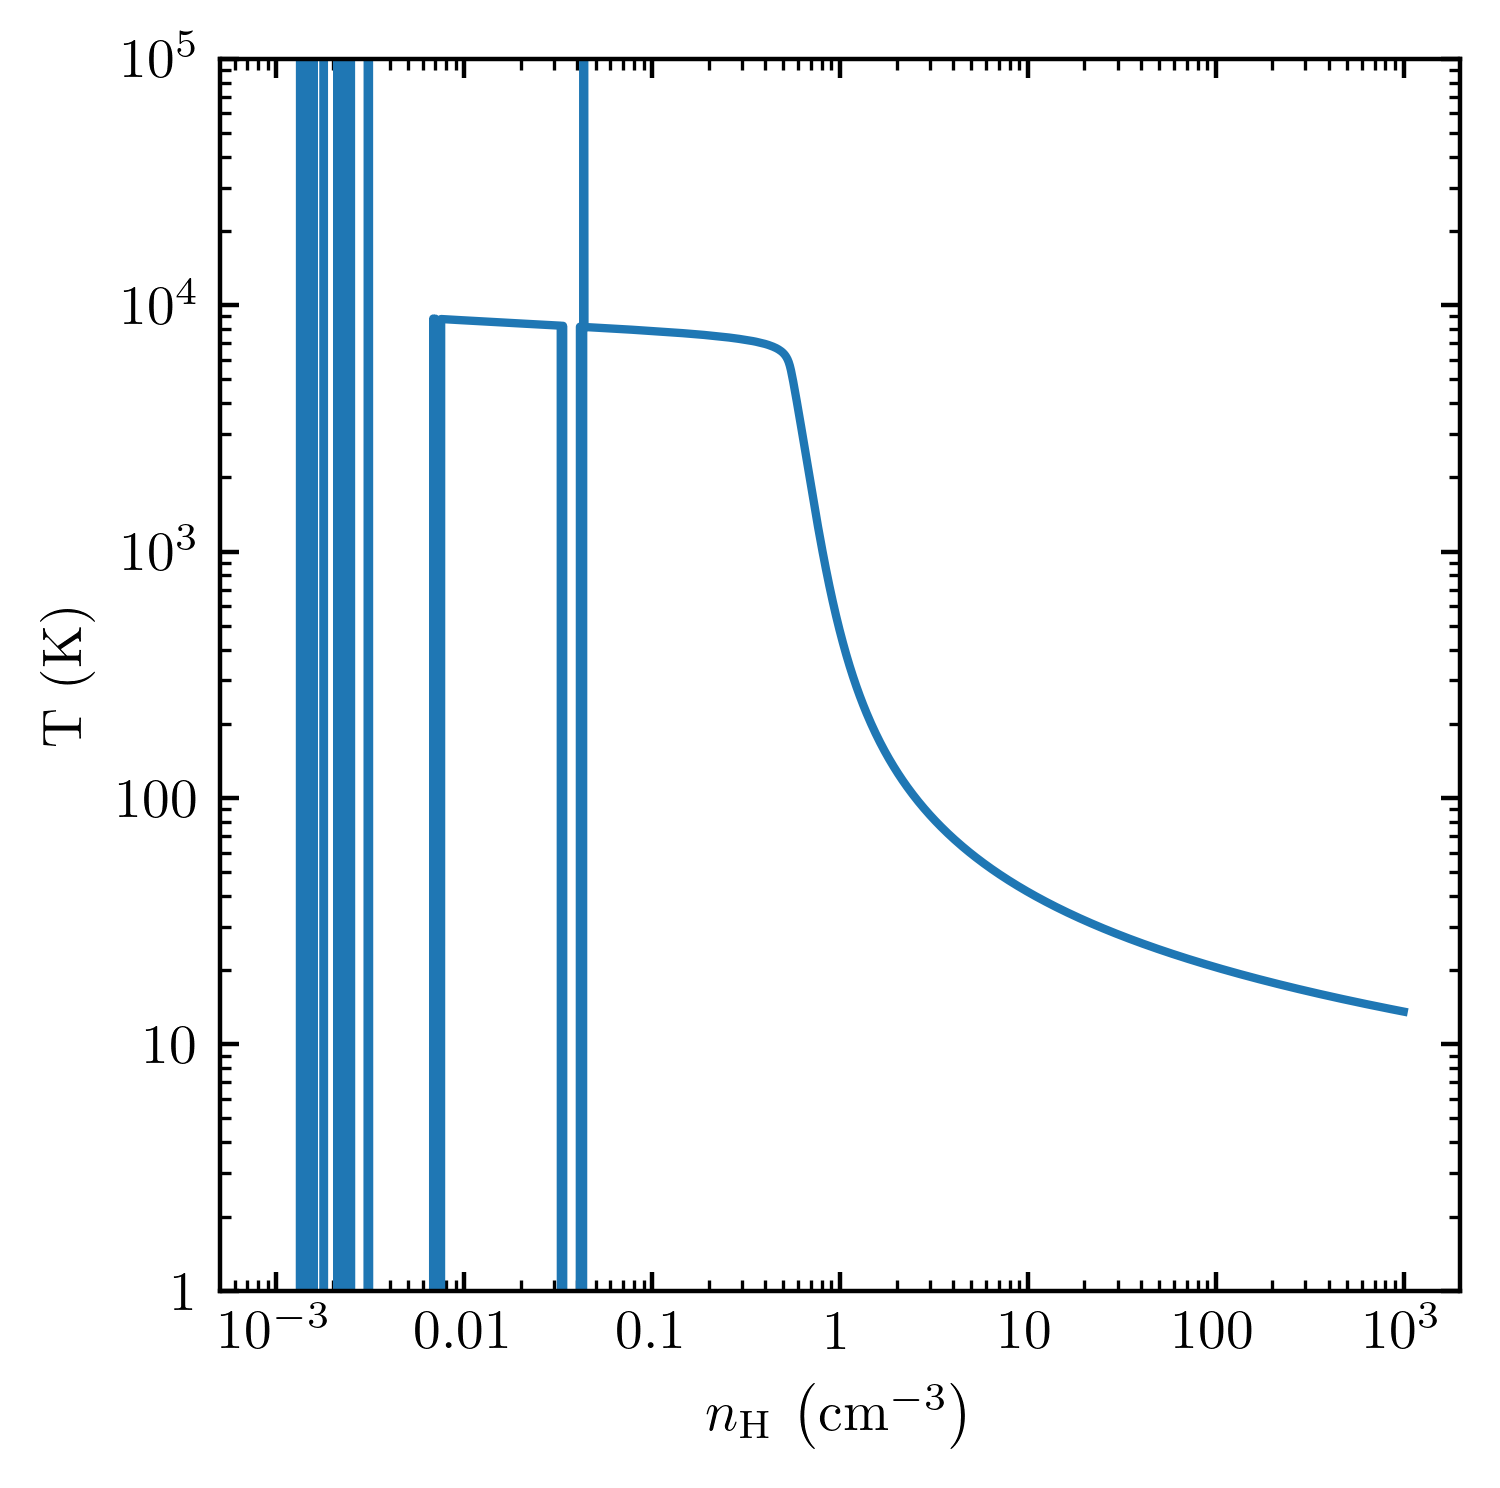

In [8]:
plt.loglog(ngrid,sol["T"])
plt.xlabel(r"$n_{\rm H}\,\left(\rm cm^{-3}\right)$")
plt.ylabel("T (K)")
plt.ylim(1,1e5)